# Graph embedding with word2vec

How can we apply word2vec to graph data? There is a critical challenge: word2vec takes sequence of words as input, while graph data are discrete and unordered. A solution to fill this gap is *random walk*, which transforms graph data into a sequence of nodes. Once we have a sequence of nodes, we can treat it as a sequence of words and apply word2vec.


## DeepWalk

![](https://dt5vp8kor0orz.cloudfront.net/7c56c256b9fbf06693da47737ac57fae803a5a4f/1-Figure1-1.png)

DeepWalk is one of the pioneering works to apply word2vec to graph data {footcite}`perozzi2014deepwalk`. It views the nodes as words and the nodes random walks on the graph as sentences, and applies word2vec to learn the node embeddings.

More specifically, the method contains the following steps:

1. Sample multiple random walks from the graph.
2. Treat the random walks as sentences and feed them to word2vev to learn the node embeddings.


There are some technical details that we need to be aware of, which we will learn by implementing DeepWalk in the following exercise.

### Exercise 01: Implement DeepWalk

In this exercise, we implement DeepWalk step by step.

#### Step 1: Data preparation

We will use the karate club network as an example.

**Load the data**

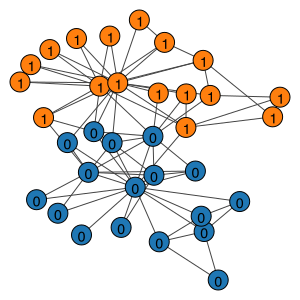

In [1]:
import igraph
import networkx as nx
import numpy as np
import seaborn as sns

g = igraph.Graph.Famous("Zachary")
A = g.get_adjacency_sparse()

# Add the community labels to the nodes for visualization
g.vs["label"] = np.unique([d[1]['club'] for d in nx.karate_club_graph().nodes(data=True)], return_inverse=True)[1]

palette = sns.color_palette().as_hex()
igraph.plot(g, vertex_color=[palette[label] for label in g.vs["label"]], bbox=(300, 300))

#### Step 2: Generate random walks

Next, we generate the training data for the word2vec model by generating multiple random walks starting from each node in the network.
Let us first implement a function to sample random walks from a given network.

In [2]:
def random_walk(net, start_node, walk_length):
    # Initialize the walk with the starting node
    walk = [start_node]

    # Continue the walk until the desired length is reached
    while len(walk) < walk_length:
        # Get the current node (the last node in the walk)
        cur = walk[-1]

        # Get the neighbors of the current node
        cur_nbrs = list(net[cur].indices)

        # If the current node has neighbors, randomly choose one and add it to the walk
        if len(cur_nbrs) > 0:
            walk.append(np.random.choice(cur_nbrs))
        else:
            # If the current node has no neighbors, terminate the walk
            break

    # Return the generated walk
    return walk

Generate 10 random walks of length 50 starting from each node.

In [3]:
n_nodes = g.vcount()
n_walkers_per_node = 10
walk_length = 50
walks = []
for i in range(n_nodes):
    for _ in range(n_walkers_per_node):
        walks.append(random_walk(A, i, walk_length))

#### Step 3: Train the word2vec model
Then, we feed the random walks to the word2vec model.

In [4]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, hs = 1)

Here,

- `vector_size` is the dimension of the embedding vectors.
- `window` indicates the maximum distance between a word and its context words. For example, in the random walk `[0, 1, 2, 3, 4, 5, 6, 7]`, the context words of node 2 are `[0, 1, 3, 4, 5]` when `window=3`.
- `min_count` is the minimum number of times a word must appear in the training data to be included in the vocabulary.

Two parameters `sg=1` and `hs=1` indicate that we are using the skip-gram model with negative sampling. Let us understand what they mean in detail as follows.

- **Skip-gram model**: it trains word2vec by predicting context words given a target word. For example, given the sentence "The quick brown fox jumps over the lazy dog", in the skip-gram model, given the target word "fox", the model will try to predict the context words "quick", "brown", "jumps", and "over". If `sg=0`, the input and output are swapped: the model will predict the target word from the context words, e.g., given the context words "quick", "brown", "jumps", and "over", the model will predict the target word "fox".

- **Hierarchical softmax**: To understand hierarchical softmax better, let's break down how the word2vec model works. The goal of word2vec is to predict context words given a target word. For example, if our target word is $w_t$ and our context word is $w_c$, we want to find the probability of $w_c$ given $w_t$. This probability is calculated using the softmax function:

    $$
    P(w_c | w_t) = \frac{\exp(\mathbf{v}_{w_c} \cdot \mathbf{v}_{w_t})}{\sum_{w \in V} \exp(\mathbf{v}_w \cdot \mathbf{u}_{w_t})}
   $$

    Here, $\mathbf{v}_w$ and $\mathbf{u}_w$ represent the vector for word $w$ as context and target respectively, and $V$ is the entire vocabulary. The tricky part is the denominator, which requires summing over all words in the vocabulary. If we have a large vocabulary, this can be very computationally expensive. Imagine having to compute 100,000 exponentials and their sum for each training example if our vocabulary size is 100,000!

    Hierarchical softmax helps us solve this problem. Instead of calculating the probability directly, it organizes the vocabulary into a binary tree, where each word is a leaf node. To find the probability of a word, we calculate the product of probabilities along the path from the root to the leaf node. This method significantly reduces the computational complexity. Instead of being proportional to the vocabulary size, it becomes proportional to the logarithm of the vocabulary size. This makes it much more efficient, especially for large vocabularies.

    ![](https://lh5.googleusercontent.com/proxy/_omrC8G6quTl2SGarwFe57qzbIs-PtGkEA5yODFE5I0Ny2IHGiJwsUhMrcuUqg5o-R2nD9hkgMuZsQJKoCggP29zXtj-Vz-X8BE)


By using the skip-gram model with hierarchical softmax, we can efficiently learn high-quality word embeddings even when dealing with large vocabularies.

Now, we extract the node embeddings from the word2vec model. In the word2vec model, the embeddings are stored in the `wv` attribute. The embedding of node $i$ is given by `model.wv[i]`.

In [5]:
embedding = []
for i in range(n_nodes):
    embedding.append(model.wv[i])
embedding = np.array(embedding)

`embedding` is the matrix of node embeddings. It has the same number of rows as the number of nodes in the network, and the number of columns is the embedding dimension.

**Print the first 3 nodes**

In [6]:
embedding[:3]

array([[-0.26126128, -0.03572951,  0.29026234,  0.409583  , -0.47722805,
        -0.32764852,  0.14788038,  0.3169038 ,  0.27099365, -0.07565458,
         0.13179769, -0.06358908,  0.03571147, -0.05889902, -0.30853978,
        -0.23068121,  0.2556093 , -0.15708576, -0.28788173, -0.08512079,
         0.15395792,  0.3885074 ,  0.3032633 ,  0.07433211,  0.30241933,
         0.02306408, -0.02056597,  0.30430248, -0.05334197, -0.01151651,
        -0.36241642,  0.27764377],
       [-0.2530832 ,  0.02889288,  0.47970778,  0.14878796, -0.26976088,
        -0.27098876,  0.36845315,  0.21580216,  0.33799824,  0.09983373,
         0.16080287, -0.06291901,  0.06544671, -0.05949009, -0.5439175 ,
        -0.38283178, -0.08761646,  0.03485427,  0.16767478, -0.11694966,
         0.1956343 ,  0.44923297,  0.5063874 , -0.07389914,  0.26030487,
         0.04156785,  0.00222216,  0.32168713,  0.20742363, -0.08275566,
        -0.3403689 ,  0.41119698],
       [-0.3119012 , -0.16259369,  0.45925754,  0.2206

Let's visualize the node embeddings using UMAP.

In [7]:
import umap
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool


reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, metric="cosine")
xy = reducer.fit_transform(embedding)

output_notebook()

# Calculate the degree of each node
degrees = A.sum(axis=1).A1

source = ColumnDataSource(data=dict(
    x=xy[:, 0],
    y=xy[:, 1],
    size=np.sqrt(degrees / np.max(degrees)) * 30,
    community=[palette[label] for label in g.vs["label"]]
))

p = figure(title="Node Embeddings from Word2Vec", x_axis_label="X", y_axis_label="Y")

p.scatter('x', 'y', size='size', source=source, line_color="black", color="community")

show(p)

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Loading BokehJS ...

#### Step 4: Clustering

One of the interesting applications with node embeddings is clustering. While we have good community detection methods, like the modularity maximization and stochastic block model, we can use clustering methods from machine learning, such as $K$-means and Gaussian mixture model. Let's see what we can get from the node embeddings.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the silhouette score
def Kmeans_with_silhouette(embedding, n_clusters_range=(2, 10)):
    silhouette_scores = []

    # Iterate over a range of cluster numbers from 2 to 9
    for n_clusters in range(*n_clusters_range):
        # Create a KMeans object with the current number of clusters
        kmeans = KMeans(n_clusters=n_clusters)

        # Fit the KMeans model to the embedding data
        kmeans.fit(embedding)

        # Calculate the silhouette score for the current clustering
        score = silhouette_score(embedding, kmeans.labels_)

        # Append the number of clusters and its corresponding silhouette score to the list
        silhouette_scores.append((n_clusters, score))

    # Find the number of clusters that has the highest silhouette score
    optimal_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

    # Create a KMeans object with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_n_clusters)

    # Fit the KMeans model to the embedding data with the optimal number of clusters
    kmeans.fit(embedding)

    # Return the labels (cluster assignments) for each data point
    return kmeans.labels_

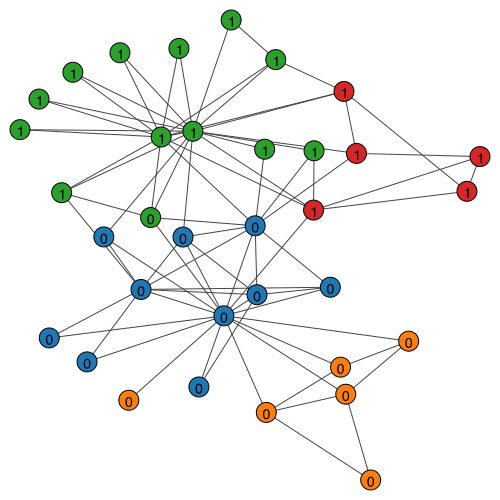

In [9]:
import seaborn as sns
labels = Kmeans_with_silhouette(embedding)
cmap = sns.color_palette().as_hex()
igraph.plot(g, vertex_color=[cmap[label] for label in labels], bbox=(500, 500))

## node2vec

node2vec is a sibling of DeepWalk proposed by {footcite}`grover2016node2vec`. Both use word2vec trained on random walks on networks. So, it appears that they are very similar. However, the following two components make them very different.

- **Biased random walk**: node2vec uses biased random walks that can move in different directions. The bias walk is parameterized by two parameters, $p$ and $q$:

    $$
    P(v_{t+1} = x | v_t = v, v_{t-1} = t) \propto
    \begin{cases}
    \frac{1}{p} & \text{if } d(v,t) = 0 \\
    1 & \text{if } d(v,t) = 1 \\
    \frac{1}{q} & \text{if } d(v,t) = 2 \\
    \end{cases}
    $$

    where $d(v,x)$ is the shortest path distance between node $v$ and $x$. A smaller $p$ leads to more biased towards the previous node, $v_{t-1} = t$. A smaller $q$ leads to more biased towards the nodes that are further away from the previous node, $v_{t-1} = t$.

    By adjusting the parameters $p$ and $q$, we can influence the random walk to behave more like either breadth-first sampling (BFS) or depth-first sampling (DFS).

    - **Breadth-First Sampling (BFS)**: This type of sampling explores all the neighbors of a node before moving on to the next level of neighbors. It is useful for capturing community structures within the graph. When we set the parameters to favor BFS, the resulting embeddings will reflect these community structures.

    - **Depth-First Sampling (DFS)**: This type of sampling goes deep into the graph, exploring as far as possible along each branch before backtracking. It is useful for capturing structural equivalence, where nodes that have similar roles in the graph (even if they are not directly connected) are represented similarly. When we set the parameters to favor DFS, the resulting embeddings will reflect these structural equivalences.

    ![](https://www.researchgate.net/publication/354654762/figure/fig3/AS:1069013035655173@1631883977008/A-biased-random-walk-procedure-of-node2vec-B-BFS-and-DFS-search-strategies-from-node-u.png)

    The embeddings generated by node2vec can capture different aspects of the graph depending on the sampling strategy used. With BFS, we capture community structures, and with DFS, we capture structural equivalence.

    ![](https://miro.medium.com/v2/resize:fit:1138/format:webp/1*nCyF5jFSU5uJVdAPdf-0HA.png)

- **Negative sampling**: node2vec uses negative sampling, instead of hierarchical softmax. This difference appears to be minor, but it has significant consequences on the characteristics of the embeddings. This is beyond the scope of this lecture, but you can refer to {footcite}`kojaku2021neurips` and {footcite}`dyer2014notes` for more details.


### Exercise 02: Implement node2vec

Let's implement the biased random walk for node2vec

In [10]:
def node2vec_random_walk(net, start_node, walk_length, p, q):
    """
    Sample a random walk starting from start_node.
    """
    # Initialize the walk with the start_node
    walk = [start_node]

    # Continue the walk until it reaches the desired length
    while len(walk) < walk_length:
        # Get the current node in the walk
        cur = walk[-1]
        # Get the neighbors of the current node
        cur_nbrs = list(net[cur].indices)
        # Check if the current node has any neighbors
        if len(cur_nbrs) > 0:
            # If the walk has just started, randomly choose the next node from the neighbors
            if len(walk) == 1:
                walk.append(np.random.choice(cur_nbrs))
            else:
                # Get the previous node in the walk
                prev = walk[-2]
                # Use the alias sampling method to choose the next node based on the bias parameters p and q
                next_node = alias_sample(net, cur_nbrs, prev, p, q)
                # Append the chosen next node to the walk
                walk.append(next_node)
        else:
            # If the current node has no neighbors, terminate the walk
            break

    return walk

def alias_sample(net, neighbors, prev, p, q):
    """
    Helper function to sample the next node in the walk.
    """
    # Implement the logic to sample the next node based on the bias parameters p and q
    # You can use the formula provided in the instructions to calculate the probabilities
    # and then sample the next node accordingly.
    # Initialize an empty list to store the unnormalized probabilities for each neighbor
    unnormalized_probs = []

    # Iterate over each neighbor of the current node
    for neighbor in neighbors:
        # If the neighbor is the same as the previous node in the walk
        if neighbor == prev:
            # Append the probability 1/p to the unnormalized probabilities list
            unnormalized_probs.append(1 / p)
        # If the neighbor is connected to the previous node in the walk
        elif neighbor in net[prev].indices:
            # Append the probability 1 to the unnormalized probabilities list
            unnormalized_probs.append(1)
        # If the neighbor is not connected to the previous node in the walk
        else:
            # Append the probability 1/q to the unnormalized probabilities list
            unnormalized_probs.append(1 / q)

    # Calculate the normalization constant by summing all unnormalized probabilities
    norm_const = sum(unnormalized_probs)

    # Normalize the probabilities by dividing each unnormalized probability by the normalization constant
    normalized_probs = [float(prob) / norm_const for prob in unnormalized_probs]

    # Randomly choose the next node from the neighbors based on the normalized probabilities
    next_node = np.random.choice(neighbors, size=1, p=normalized_probs)[0]

    # Return the chosen next node
    return next_node

Now, let's set up the word2vec model for node2vec.

In [11]:
walks = []
p = 1
q = 0.1
for i in range(n_nodes):
    for _ in range(n_walkers_per_node):
        walks.append(node2vec_random_walk(A, i, walk_length, p, q))
model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, hs = 1)

where `hs=0` indicates that we are using negative sampling.
Notice that we set `sg=1` and `hs=1` instead of `sg=1` and `hs=0` in DeepWalk. This is because node2vec uses the skip-gram model with negative sampling.

Now, we extract the node embeddings from the word2vec model.

In [12]:
embedding = []
for i in range(n_nodes):
    embedding.append(model.wv[i])
embedding = np.array(embedding)

Let's visualize the node embeddings from node2vec.

In [13]:
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, metric="cosine")
xy = reducer.fit_transform(embedding)

output_notebook()

# Calculate the degree of each node
degrees = A.sum(axis=1).A1

source = ColumnDataSource(data=dict(
    x=xy[:, 0],
    y=xy[:, 1],
    size=np.sqrt(degrees / np.max(degrees)) * 30,
    community=[palette[label] for label in g.vs["label"]],
    name = [str(i) for i in range(n_nodes)]
))

p = figure(title="Node Embeddings from Word2Vec", x_axis_label="X", y_axis_label="Y")

p.scatter('x', 'y', size='size', source=source, line_color="black", color="community")

hover = HoverTool()
hover.tooltips = [
    ("Name", "@name"),
    ("Community", "@community")
]
p.add_tools(hover)

show(p)

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Loading BokehJS ...

The results for clustering are as follows:

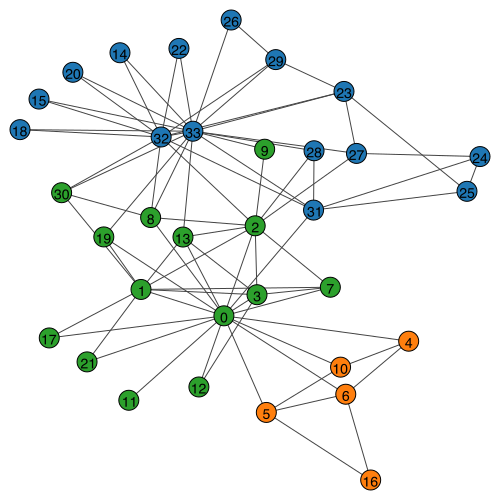

In [14]:
import seaborn as sns

labels = Kmeans_with_silhouette(embedding)


cmap = sns.color_palette().as_hex()
igraph.plot(g, vertex_color=[cmap[label] for label in labels], bbox=(500, 500), vertex_label=["%d" %  d for d in  np.arange(n_nodes)])

## LINE

LINE {footcite}`tang2015line` is another pioneering work to learn node embeddings by directly optimizing the graph structure.
It is equivalent to node2vec with $p=1$, $q=1$, and window size 1.


```{footbibliography}

```